<a href="https://colab.research.google.com/github/Abdulla-asim/DeepLearning/blob/main/Notebooks/06_PyTorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Transfer Learning

## 0. Getting Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  torch_version = torch.__version__.split(".")
  vision_version = torchvision.__version__.split(".")
  assert int(torch_version[0]) > 1 or int(torch_version[1]) >= 12, "torch version should be 1.12+"
  assert int(vision_version[1]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# try to get torchinfo, install it if it dosen't work
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldnt't find torchinfo!...Installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from github if it dosent work
try:
  from going_modular.going_modular import data_setup, engine
except:
  #get the going modular scripts
  print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] Couldnt't find torchinfo!...Installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1458), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder does not exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip") as f:
    print(f"Unzipping pizza, steak, sushi data...")
    f.extractall(image_path)

  # remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # 1. Reshape all images to 224 x 224 (some models may require diffrent sizes)
    transforms.ToTensor(),  # 2. Turn the image values between 0 and 1.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [given list] (across each color channel)
                         std=[0.299, 0.244, 0.255]) # 4. A standard deviaton of [given list] (across each color channel)
])

In [ ]:
# Creating and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=manual_transform, # reaize, scale them to be between 0 and 1, normalize them.
                                                                                batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d5f61ddb3d0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d5f61e1f2d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.1 Choose a pretrained model
`chose efficientnet`

### 3.2 Setting up a pretrained model

In [ ]:
# OLD: Setup the model with pretrained weights and send it to the target device
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# model # lengthy output

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s]


### 3.3 Getting the summary of our model with `torchinfo.summary()`

In [ ]:
# Print a summary using torchinfo (uncommenet for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is input size and not input shape
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad = False
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)

# Recrete the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same output units as out number of classes
                    bias=True)
).to(device)

In [ ]:
# Do a summary of model after freezing features and changing output classifier layer
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train Model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# SEt the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 22.566 seconds


### 5. Evaluate model by plotting loss curve

[INFO] Couldn't find helper_functions.py. Downloading...


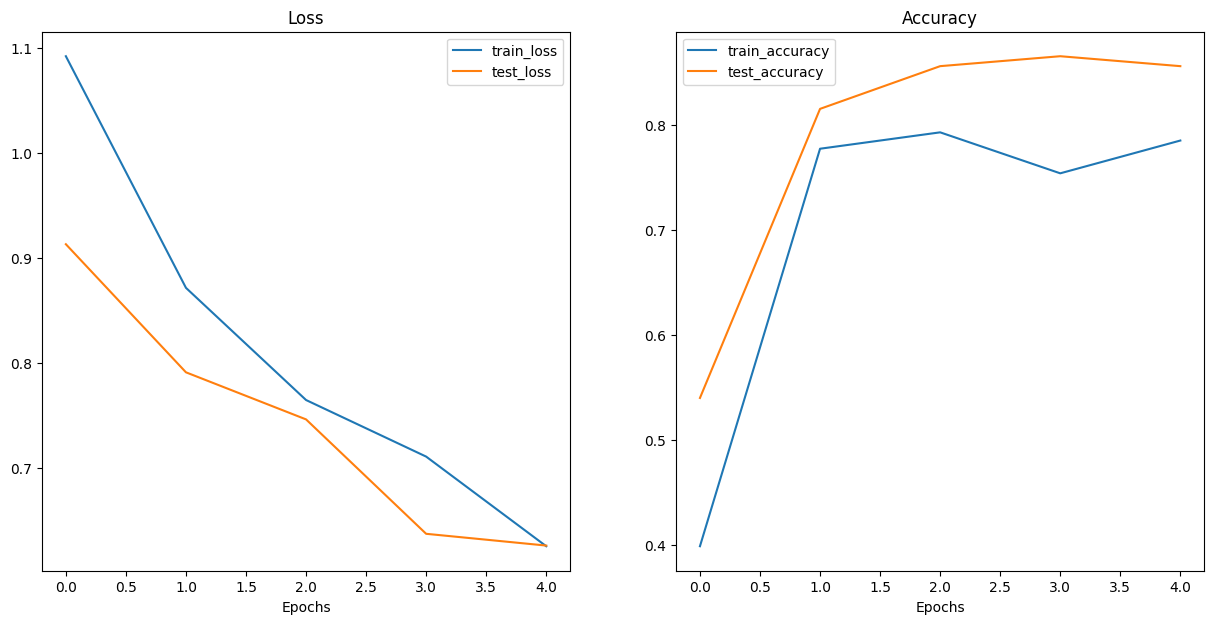

In [ ]:
# Get the plot_loss_curves() function from helper_functions.pu, download if not available
try:
  from helper_functins import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py. Downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        class_names: List[str],
                        image_path: str,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device
                        ):
  # 2. Open the image
  img = Image.open(image_path)

  # 3. Create the tranform for the image (if not exists)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  ###Predict the image###

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on the model for evaluation
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimension to the image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make prediction on image with extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # 9. Convert prediction pobabilites -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10 plot the image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

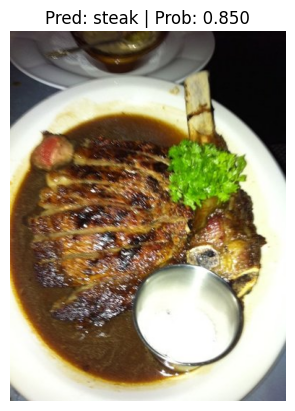

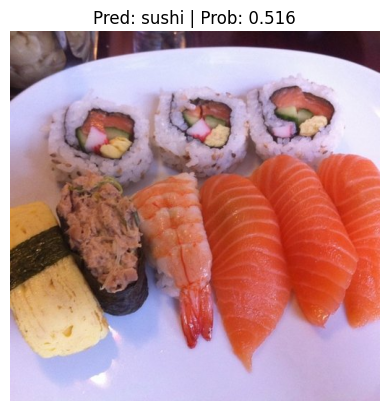

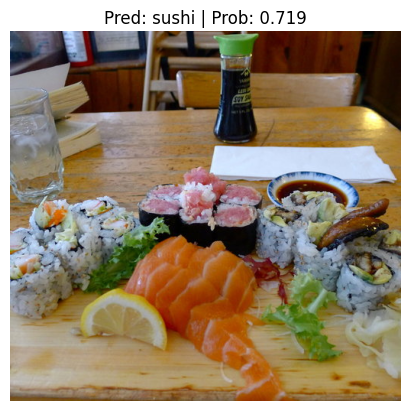

In [ ]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # Get list of all images in test dir
test_image_path_sample = random.sample(population=test_image_path_list,
                                        k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      class_names=class_names,
                      image_path=image_path,
                      image_size=(224, 225),
                      # transform = weights.transforms()
                      )

### 6.1 Making predictions on a custom image

data/04-pizza-dad.jpeg already exists, skipping download.


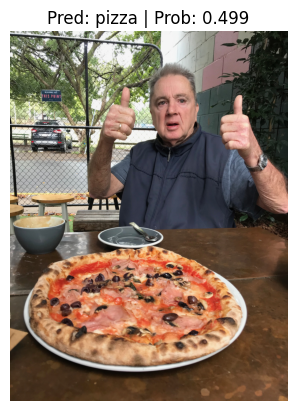

In [ ]:
# Download a custom image
import requests

# Setup a custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Downlaod the image if it dosen't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom imgea
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    #transform=weights.transforms(),
                    class_names=class_names)